<a href="https://colab.research.google.com/gist/jonghank/13382cbcfb89e625c92346fbe3d65125/image_in-painting_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image in-painting


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\argmin}{{\text{argmin}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\E}{\mathbf{E}}
\newcommand{\var}{\mathbf{var}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\B}{\mathbf{B}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


You are given an $m \times n$ corrupted image 

$$X\in \R^{m\times n}$$ 

some of whose pixel values are missing, and your job is to in-paint the image by guessing the missing pixel values.

The missing pixels can be represented by an $m\times n$ binary matrix 

$$B\in\B^{m\times n}$$

where $B_{ij}=1$ implies that $X_{ij}$ is known, and $B_{ij}=0$ means $X_{ij}$ is unknown. Note that this matrix $B$ is given in some lucky cases, but it doesn't always happen in which cases you have to identify which pixels are reliable and which are not. In this problem, we assume that $B$ is given, or at least can be identified reliably.

Then your job is to reconstruct, by using $X$ and $B$, the corrupted image by filling appropriate pixel values into the unknown pixels where $B_{ij}=0$, so that your reconstructed image looks natural.



We first download a black and white image from the course webpage. The image was corrupted by white characters written on top. So we will try to in-paint the image by guessing the missing pixel values at those white pixels. 

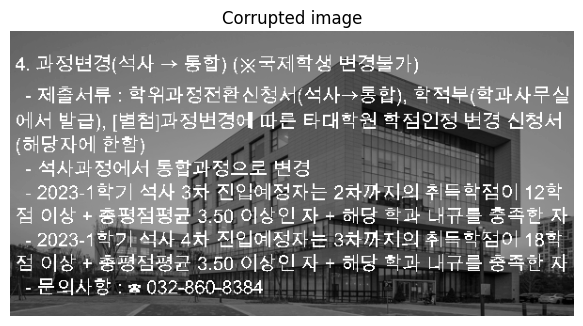

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
X = Image.open(requests.get("https://jonghank.github.io/ase7030/files/aerospace_building_corrupted.png", stream=True).raw)
X = np.array(X)/255
m, n = X.shape

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.axis('off')
plt.title('Corrupted image')
plt.show()

So the missing pixels can be found by searching for the white pixels.

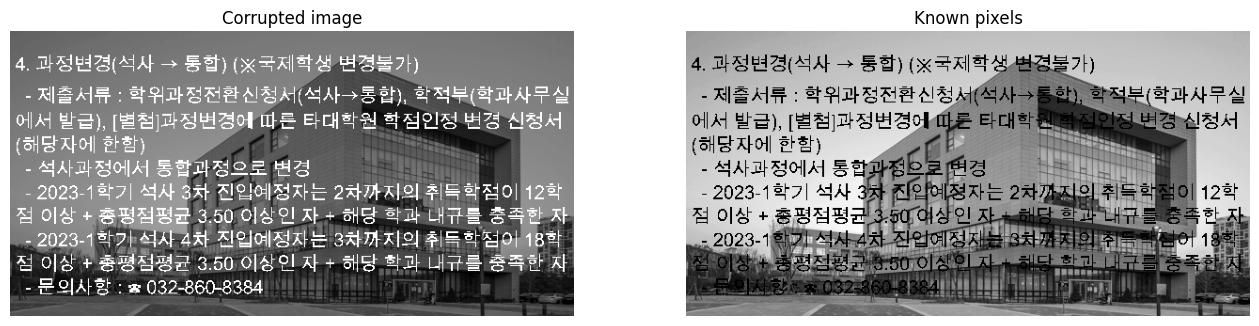

In [2]:
B = (X<0.9)*1

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.axis('off')
plt.title('Corrupted image')
plt.subplot(122)
plt.imshow(B*X, cmap='gray')
plt.axis('off')
plt.title('Known pixels')
plt.show()

Let $p$ be the number of known pixels and $q$ be the number of unknown pixels, so $mn = p+q$.

We first let $x\in\R^{mn}$ be the vectorized version of the image, $X\in\R^{m\times n}$,

\begin{align*}
  x &=\text{vec}\left(X\right) \\
  X &=\text{vec}^{-1}\left(x\right)
\end{align*}

so the vectorization is nothing but stacking all the columns into a single long column, and the inversion is just going backwards. Note that the vectorization is linear and explicitly represented by

$$
{\displaystyle {\text{vec}}({X} )=\sum _{i=1}^{n} e_i\otimes X e_i}
$$

where $e_i$ is the $i$-th unit vector in $\R^n$, and $\otimes$ represents the Kronecker product.

We then separate the image into two parts, the known part and the unknown part, since we know which are which from ${B}$. Let $x_\text{k}$ is the $p$-vector containing the known pixel values, and $x_\text{u}$ be the $q$-vector of unknown pixel values that we will have to find.

\begin{align*}
x_\text{k}&\in\R^{p} \\
x_\text{u}&\in\R^{q} 
\end{align*}

We will define some operators to build the image from these two vectors.

\begin{align*}
Z_\text{k}&\in\R^{mn \times p} \\
Z_\text{u}&\in\R^{mn \times q} 
\end{align*}

so that

$$\text{vec}(X) = Z_\text{k}x_\text{k} + Z_\text{u}x_\text{u}$$

For example, $Z_\text{k}$ is a lifting operator that maps a $p$-vector $x_\text{k}$ to a $mn$-vector by zero-padding appropriately, and a similar but complementary operation is done by $Z_\text{u}$. Note that $Z_\text{k}$ and $Z_\text{u}$ are made of columns exclusively taken from the $mn\times mn$ identity matrix.

For example, the known part of the corrupted image (with zeros on the unknown pixels) can be formed from

$$ \text{vec}^{-1}(Z_\text{k}x_\text{k}) $$

Note that the image $X$ is a simple linear function of the unknown variable $x_\text{u}$, and the inpainting problem boils down to finding some good $x_\text{u}$ satisfying the linear relation. Once you have it, the reconstructed image can be obtained from

$$
X_\text{recon} = \text{vec}^{-1} ( Z_\text{k}x_\text{k} + Z_\text{u}x_\text{u} ) 
$$

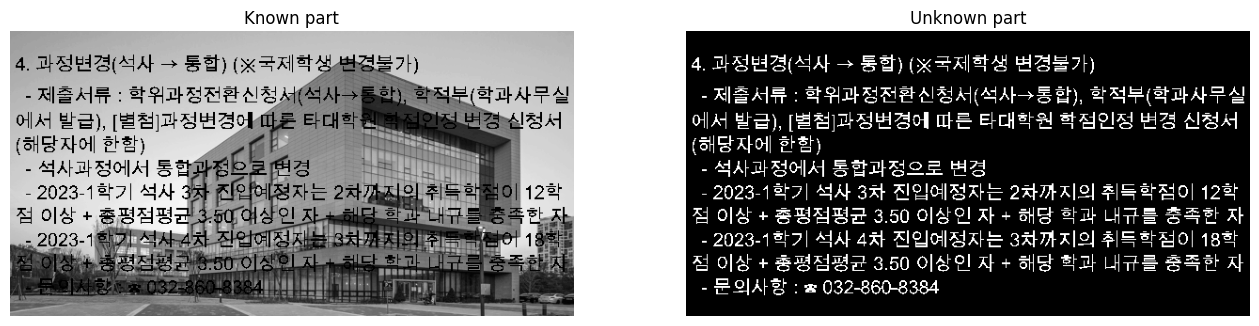

In [3]:
import numpy as np
import scipy.sparse as ssp

mn = m*n
p = np.sum(B)
q = mn - p

B_k = B.flatten('F')
B_u = 1-B.flatten('F')

Z_k = ssp.coo_matrix( ( np.ones(p), ( np.where(B_k>0)[0], range(p) ) ), 
    shape=(mn, p), dtype=np.int8)
Z_u = ssp.coo_matrix( ( np.ones(q), ( np.where(B_u>0)[0], range(q) ) ), 
    shape=(mn, q), dtype=np.int8)
x_k = Z_k.T@X.flatten('F')

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(121)
plt.imshow((Z_k@x_k).reshape(m,n, order='F'), cmap='gray')
plt.axis('off')
plt.title('Known part')
plt.subplot(122)
plt.imshow((Z_u@np.ones(q)).reshape(m,n, order='F'), cmap='gray')
plt.axis('off')
plt.title('Unknown part')
plt.show()

We define a function that quantifies "roughness" of rectangular images.

$$
\text{TV}(X) = \sum_{i=1}^{m-1}\sum_{j=1}^{n-1} \left(  |X_{ij}-X_{i+1,j}|^p + |X_{ij}-X_{i,j+1}|^p \right) 
$$

Note that this can be written as follows 

$$
\text{TV}(X) = \left\| \begin{bmatrix}{D_x \\ D_y}\end{bmatrix} \text{vec}(X) \right\|_p^p 
$$

with $D_x\in\mathbb{R}^{m(n-1) \times mn}$

$$
  D_x = \bmat{
  -1 & & & & 1 & & & & & & & & & & & &\\
  & -1 & & & & 1 & & & &\\
  & & \ddots  & & & & \ddots & & &\\
  &}
$$

returning the $m(n-1) \times mn$ column-wise differences and $D_y\in\mathbb{R}^{(m-1)n\times mn}$ 

$$
  D_x = \bmat{
  -1 & 1 & & & & & & & & & & & & & &\\
   & \ddots & \ddots & & & & &\\
  &  &  -1& 1  & & & & & & & \\
   &  & & & -1& 1& & & & & & &\\
   &  &  & & & \ddots & \ddots & \\
  &  &  &  & & &  & & & &}
$$

returning the $(m-1)n\times mn$ row-wise differences.


In [4]:
Dx = ssp.hstack( [ np.zeros( (m*(n-1),m) ), ssp.eye( m*(n-1) ) ] ) \
   - ssp.hstack( [ ssp.eye( m*(n-1) ), np.zeros( (m*(n-1),m) ) ] )
Dy = ssp.kron( ssp.eye(n), np.diff(np.eye(m), axis=0) )

DD = ssp.vstack( [ Dx, Dy ] )

Now the inpainting problem is finding $x_\text{u}$ that minimizes $\text{TV}(X_\text{recon})$, in other words, 

$$
\underset{x_\text{u}}{\text{minimize}}\quad \left\| \begin{bmatrix}{D_x \\ D_y}\end{bmatrix} \Big( Z_\text{k}x_\text{k} + Z_\text{u}x_\text{u} \Big)  \right\|_p
$$

First, the 2-norm reconstruction via ordinary least squares solution.

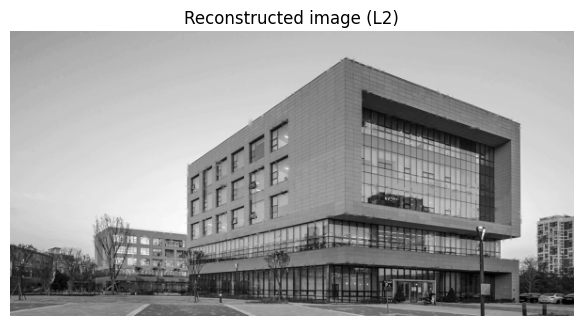

In [5]:
import scipy.sparse.linalg as sla

A_MATRIX = DD@Z_u
B_MATRIX = DD@Z_k@x_k

x_u = sla.lsqr(A_MATRIX, -B_MATRIX)[0]
X_recon_L2 = (Z_k@x_k + Z_u@x_u).reshape(m, n, order='F')

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(121)
plt.imshow(X_recon_L2, cmap='gray')
plt.title('Reconstructed image (L2)')
plt.axis('off')
plt.show()

The 1-norm reconstruction can be obtained by numerically solving the problem via `cvxpy` with the SCS solver.

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 04 04:55:18 PM: Your problem has 20544 variables, 0 constraints, and 0 parameters.
(CVXPY) May 04 04:55:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 04:55:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 04:55:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 04:55:18 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 04 04:55:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

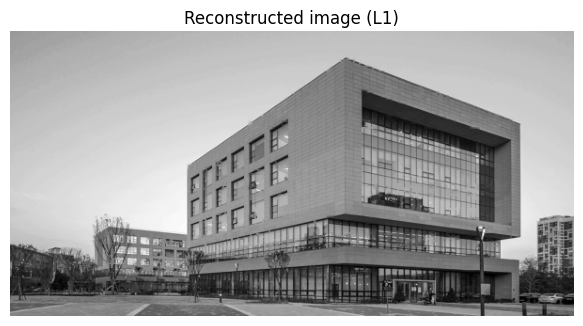

In [6]:
import cvxpy as cp

v = cp.Variable(q)
obj = cp.Minimize( cp.norm( A_MATRIX@v + B_MATRIX, 1 ) )
prob = cp.Problem(obj)
prob.solve(verbose=True)
x_u = v.value

X_recon_L1 = (Z_k@x_k + Z_u@x_u).reshape(m, n, order='F')

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(121)
plt.imshow(X_recon_L1, cmap='gray')
plt.title('Reconstructed image (L1)')
plt.axis('off')
plt.show()

Now compare your reconstructed images with the clean original image. 

Can you tell the difference?

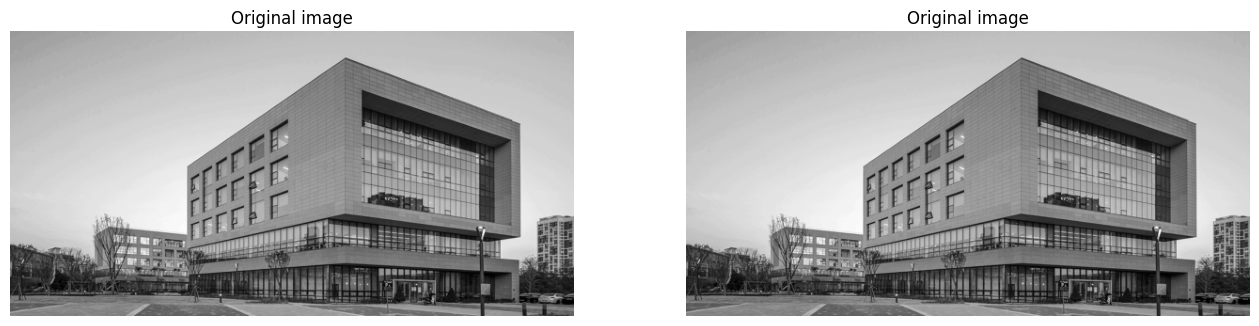

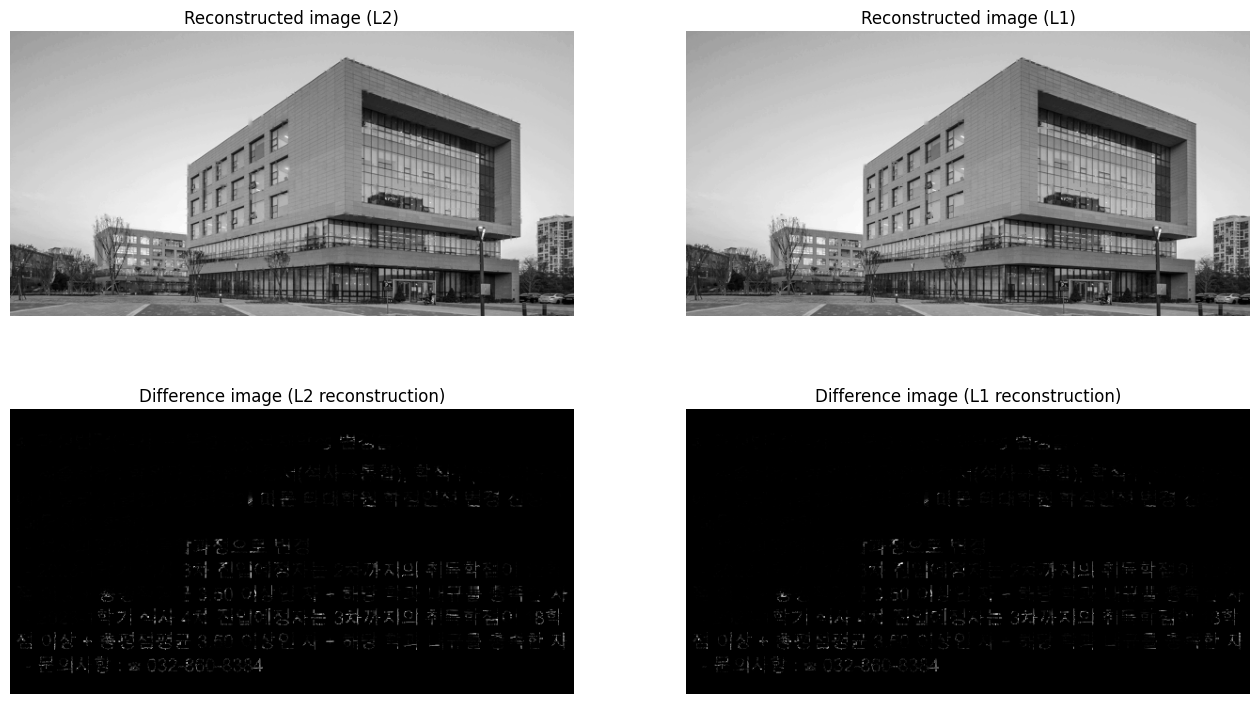

In [7]:
X_clean = Image.open(requests.get("http://jonghank.github.io/ase7030/files/aerospace_building_clean.png", stream=True).raw)
X_clean = np.array(X_clean)/255

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(221)
plt.imshow(X_clean, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(222)
plt.imshow(X_clean, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

plt.figure(figsize=(16,9), dpi=100)
plt.subplot(221)
plt.imshow(X_recon_L2, cmap='gray')
plt.title('Reconstructed image (L2)')
plt.axis('off')
plt.subplot(222)
plt.imshow(X_recon_L1, cmap='gray')
plt.title('Reconstructed image (L1)')
plt.axis('off')
plt.subplot(223)
plt.imshow(np.abs(X_clean-X_recon_L2), cmap='gray')
plt.title('Difference image (L2 reconstruction)')
plt.axis('off')
plt.subplot(224)
plt.imshow(np.abs(X_clean-X_recon_L1), cmap='gray')
plt.title('Difference image (L1 reconstruction)')
plt.axis('off')
plt.show()
